# Import

In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Descriptors

import pathlib

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from matplotlib import rcParams
rcParams["font.size"] = 20

# Read Data

In [3]:
qm9 = pd.read_csv("qm_ext_plus.csv")
qm9.index = qm9["Unnamed: 0"]
qm9.drop(columns=["Unnamed: 0"], inplace=True)
qm9["mol"] = qm9["smiles"].apply(Chem.MolFromSmiles)

In [4]:
qm9.dropna()

,smiles,mu,alpha,homo,lumo,gap,zpve,cv,u0,u298,h298,g298,num_atoms,mol
Unnamed: 0,,,,,,,,,,,,,,
0,C,0.0000,13.210000,-0.387700,0.117100,0.504800,0.044749,6.469,-40.478930,-40.476062,-40.475117,-40.498597,1,<rdkit.Chem.rdchem.Mol object at 0x7f01990d06a0>
1,N,1.6256,9.460000,-0.257000,0.082900,0.339900,0.034358,6.316,-56.525887,-56.523026,-56.522082,-56.544961,1,<rdkit.Chem.rdchem.Mol object at 0x7f01990d0ac0>
2,O,1.8511,6.310000,-0.292800,0.068700,0.361500,0.021375,6.002,-76.404702,-76.401867,-76.400922,-76.422349,1,<rdkit.Chem.rdchem.Mol object at 0x7f01990d0580>
3,C#C,0.0000,16.280000,-0.284500,0.050600,0.335100,0.026841,8.574,-77.308427,-77.305527,-77.304583,-77.327429,2,<rdkit.Chem.rdchem.Mol object at 0x7f01990d0ca0>
4,C#N,2.8937,12.990000,-0.360400,0.019100,0.379600,0.016601,6.278,-93.411888,-93.409370,-93.408425,-93.431246,2,<rdkit.Chem.rdchem.Mol object at 0x7f01990d0be0>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155584,CCCCCC(Cl)(Cl)Cl,1.6998,91.438949,-0.437290,0.151861,0.589151,0.160407,39.627,-1612.899018,-1615.123029,-1612.726294,-1612.777780,9,<rdkit.Chem.rdchem.Mol object at 0x7f01978e6020>
155585,CCCNCC(Cl)(Cl)Cl,1.0758,88.241518,-0.375428,0.153217,0.528645,0.149152,39.102,-1628.886186,-1631.151460,-1628.724865,-1628.775694,9,<rdkit.Chem.rdchem.Mol object at 0x7f01978e6080>
155586,CCCOCC(Cl)(Cl)Cl,5.6070,83.982178,-0.429966,0.153852,0.583818,0.136714,37.858,-1648.698216,-1651.009167,-1648.549519,-1648.600105,9,<rdkit.Chem.rdchem.Mol object at 0x7f01978e60e0>


In [5]:
db_conf = pd.read_parquet("db_conf.parquet")
db_conf.index = db_conf["db_idx"]
db_conf.drop(columns=["Unnamed: 0", "db_idx"], inplace=True)
db_conf["mol"] = db_conf["smiles"].apply(Chem.MolFromSmiles)
# db_conf.drop(columns=["CONF", "CONFCl", "CONFClBr", "CONFClBrI"], inplace=True)
db_conf = db_conf.reset_index(drop=True)

In [6]:
na_ind = db_conf[db_conf.iloc[:,4:-1].isna().all(axis=1)].index

In [7]:
db_conf = db_conf.drop(index=na_ind)
db_conf = db_conf.reset_index(drop=True)

# Labels Encoding

In [8]:
from sklearn import preprocessing

In [9]:
le = preprocessing.LabelEncoder()
le.fit(["nB", "B"])
db_conf["class_encoded"] = le.transform(db_conf["Experimental BCF class"])

In [10]:
db_conf["class_encoded"] = db_conf["class_encoded"].replace({1:0, 0:1})

In [11]:
db_conf

,smiles,Experimental logarithmic BCF,Experimental BCF class,FQD_2,FQD_3,FQD_4,FQD_5,FQD_6,FQD_7,FQD_8,FQD_9,mol,class_encoded
0,CNc1cccc(C)c1,0.849,nB,[6],None,None,None,[213],"[929, 939]","[4340, 5388]",[32107],<rdkit.Chem.rdchem.Mol object at 0x7f01955fe5c0>,0
1,CC(COc1ccc(Oc2ccccc2)cc1)Oc1ccccn1,3.140,B,"[6, 7]","[12, 13, 14]","[21, 39, 40, 41]","[81, 84, 134, 136]","[213, 214, 277, 395, 548]","[948, 953, 1578]","[4590, 5397, 5402]","[31844, 33001, 33006]",<rdkit.Chem.rdchem.Mol object at 0x7f01955febc0>,1
2,CCCCCCCC/C=C\CCCCCCCCCCCCC,1.176,nB,[6],[12],[38],[132],[542],[2719],[14787],[123245],<rdkit.Chem.rdchem.Mol object at 0x7f0194eaeec0>,0
3,Clc1ccccc1Cl,2.500,nB,None,None,None,None,[213],[134076],[135441],None,<rdkit.Chem.rdchem.Mol object at 0x7f0194eaeda0>,0
4,Nc1cccc([N+](=O)[O-])c1,0.522,nB,None,None,None,None,[213],[939],[4360],[131914],<rdkit.Chem.rdchem.Mol object at 0x7f0194eaed40>,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,CC1=C(C)S(=O)(=O)CCS1(=O)=O,0.633,nB,[6],None,None,None,"[133896, 133900]","[134043, 134044, 134066, 134068]","[135086, 135404, 135405]",[145115],<rdkit.Chem.rdchem.Mol object at 0x7f0194e9b400>,0
835,FC(F)(F)c1ccc(Cl)c(Cl)c1,3.176,B,[6],None,None,None,[213],"[929, 134076]","[134378, 134382, 135441]",[137748],<rdkit.Chem.rdchem.Mol object at 0x7f0194e9b460>,1
836,CN(C)[C@@H]1C(=O)C(C(=N)O)=C(O)[C@@]2(O)C(=O)C...,-0.222,nB,"[5, 6, 7]","[10, 12, 13]","[17, 20, 21, 34, 37, 38, 39, 41]","[54, 67, 68, 70, 71, 80, 81, 82, 83, 127, 131,...","[213, 224, 226, 228, 254, 258, 259, 260, 271, ...","[929, 948, 1092, 1094, 1099, 1104, 1119, 1129,...","[4341, 4957, 4959, 5378, 5407, 5809, 5841, 584...","[26263, 26273, 28867, 32083, 32170, 32193, 322...",<rdkit.Chem.rdchem.Mol object at 0x7f0194e9b4c0>,0
837,CC(C)N(C(=O)CCl)c1ccccc1,1.568,nB,"[5, 6]","[10, 11, 12]","[18, 35]","[69, 73, 128]","[213, 255, 262, 288, 386]","[939, 1121, 1626, 1677]","[5388, 7443]","[25503, 26283, 32992]",<rdkit.Chem.rdchem.Mol object at 0x7f0194e9b520>,0


In [12]:
db_conf["mol"] = db_conf["smiles"].apply(Chem.MolFromSmiles)
db_conf["num_atoms"] = db_conf["mol"].apply(lambda x: x.GetNumAtoms())

# Generate FQDs

In [13]:
db_conf_filled = db_conf.copy()

In [14]:
qprops = "mu,alpha,homo,lumo,gap,zpve,u0,u298,h298,g298,cv".split(",")

In [15]:
import statistics
def calculate_FQDs(indices, patterns_db, quantum_property):
    if isinstance(indices, int) and indices == 0:
        return np.NaN
    if indices is None:
        return np.NaN
    ret = []
    for i in indices:
        ret.append(patterns_db[quantum_property][i])
    return statistics.mean(ret)

def calculate_FQDs_quant(mol, indices, patterns_db, quantum_property):
    if isinstance(indices, int) and indices == 0:
        return np.NaN
    if indices is None:
        return np.NaN
    ret = []
    for i in indices:
        n_occurences = len(list(mol.GetSubstructMatch(patterns_db["mol"][i])))
        ret.append(patterns_db[quantum_property][i] * n_occurences)
    return statistics.mean(ret)

In [16]:
# for prop in qprops:
#     for num in range(2, 10):
#         db_conf_filled[f"FQD_{num}_{prop}"] = db_conf_filled[f"FQD_{num}"].apply(calculate_FQDs, patterns_db=qm9, quantum_property=prop)

In [17]:
# for prop in qprops:
#     for num in range(2, 10):
#         db_conf_filled[f"FQD_{num}_{prop}_per_atom"] = db_conf_filled[f"FQD_{num}_{prop}"] / db_conf_filled["num_atoms"]

# Quant FQDs

In [18]:
for prop in qprops:
    for num in range(2, 10):
        db_conf_filled[f"quant_FQD_{num}_{prop}"] = db_conf_filled["mol"].apply(lambda x: calculate_FQDs_quant(x,
                                                                          indices=db_conf_filled[db_conf_filled["mol"]==x][f"FQD_{num}"].iloc[0],
                                                                          patterns_db=qm9,
                                                                          quantum_property=prop)
                                                                         )

In [19]:
for prop in qprops:
    for num in range(2, 10):
        db_conf_filled[f"quant_FQD_{num}_{prop}_per_atom"] = db_conf_filled[f"quant_FQD_{num}_{prop}"] / db_conf_filled["num_atoms"]

In [20]:
nan_cols = db_conf.iloc[:,4:12].isna()

In [21]:
db_conf_filled = db_conf_filled.fillna(0)

In [22]:
nan_cols_colnames = [f"{x}_nan" for x in nan_cols]
nan_cols.columns = nan_cols_colnames
fqd_columns = list(db_conf_filled.columns[15:]) + nan_cols_colnames
nan_cols

,FQD_3_nan,FQD_4_nan,FQD_5_nan,FQD_6_nan,FQD_7_nan,FQD_8_nan,FQD_9_nan,mol_nan
0,True,True,True,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,True,True,True,False,False,False,True,False
4,True,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...
834,True,True,True,False,False,False,False,False
835,True,True,True,False,False,False,False,False
836,False,False,False,False,False,False,False,False
837,False,False,False,False,False,False,False,False


In [23]:
db_conf_filled = pd.concat([db_conf_filled, nan_cols], axis=1)
db_conf_filled

,smiles,Experimental logarithmic BCF,Experimental BCF class,FQD_2,FQD_3,FQD_4,FQD_5,FQD_6,FQD_7,FQD_8,...,quant_FQD_8_cv_per_atom,quant_FQD_9_cv_per_atom,FQD_3_nan,FQD_4_nan,FQD_5_nan,FQD_6_nan,FQD_7_nan,FQD_8_nan,FQD_9_nan,mol_nan
0,CNc1cccc(C)c1,0.849,nB,[6],0,0,0,[213],"[929, 939]","[4340, 5388]",...,25.429333,34.071000,True,True,True,False,False,False,False,False
1,CC(COc1ccc(Oc2ccccc2)cc1)Oc1ccccn1,3.140,B,"[6, 7]","[12, 13, 14]","[21, 39, 40, 41]","[81, 84, 134, 136]","[213, 214, 277, 395, 548]","[948, 953, 1578]","[4590, 5397, 5402]",...,8.696556,11.601875,False,False,False,False,False,False,False,False
2,CCCCCCCC/C=C\CCCCCCCCCCCCC,1.176,nB,[6],[12],[38],[132],[542],[2719],[14787],...,13.616348,17.217000,False,False,False,False,False,False,False,False
3,Clc1ccccc1Cl,2.500,nB,0,0,0,0,[213],[134076],[135441],...,24.767000,0.000000,True,True,True,False,False,False,True,False
4,Nc1cccc([N+](=O)[O-])c1,0.522,nB,0,0,0,0,[213],[939],[4360],...,23.248000,23.053500,True,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,CC1=C(C)S(=O)(=O)CCS1(=O)=O,0.633,nB,[6],0,0,0,"[133896, 133900]","[134043, 134044, 134066, 134068]","[135086, 135404, 135405]",...,23.407333,30.375750,True,True,True,False,False,False,False,False
835,FC(F)(F)c1ccc(Cl)c(Cl)c1,3.176,B,[6],0,0,0,[213],"[929, 134076]","[134378, 134382, 135441]",...,16.680667,21.668250,True,True,True,False,False,False,False,False
836,CN(C)[C@@H]1C(=O)C(C(=N)O)=C(O)[C@@]2(O)C(=O)C...,-0.222,nB,"[5, 6, 7]","[10, 12, 13]","[17, 20, 21, 34, 37, 38, 39, 41]","[54, 67, 68, 70, 71, 80, 81, 82, 83, 127, 131,...","[213, 224, 226, 228, 254, 258, 259, 260, 271, ...","[929, 948, 1092, 1094, 1099, 1104, 1119, 1129,...","[4341, 4957, 4959, 5378, 5407, 5809, 5841, 584...",...,8.633506,10.959239,False,False,False,False,False,False,False,False
837,CC(C)N(C(=O)CCl)c1ccccc1,1.568,nB,"[5, 6]","[10, 11, 12]","[18, 35]","[69, 73, 128]","[213, 255, 262, 288, 386]","[939, 1121, 1626, 1677]","[5388, 7443]",...,18.348571,20.109643,False,False,False,False,False,False,False,False


# Generate RDKit descriptors

In [24]:
descriptors_names = [ x[0] for x in Descriptors._descList ] #list of all RDKit Descriptors
calculator = MoleculeDescriptors.MolecularDescriptorCalculator( descriptors_names )
descriptors = pd.DataFrame()
maccs_keys = pd.DataFrame()
morgan_fp = pd.DataFrame()
for mol in db_conf_filled["mol"]:
    descriptors = descriptors.append([calculator.CalcDescriptors(mol)])
    maccs_keys = maccs_keys.append(pd.Series(np.asarray(MACCSkeys.GenMACCSKeys(mol))), ignore_index=True)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 4, nBits=2048)
    fp_vect = np.zeros((1,))
    AllChem.DataStructs.ConvertToNumpyArray(fp, fp_vect)
    morgan_fp = morgan_fp.append(pd.Series(fp_vect), ignore_index=True)
cols_rdkit = descriptors_names + [f"MACCS_key{x}" for x in range(maccs_keys.shape[1])] + [f"MorganFP_bit_{x}" for x in range(2048)]
cols = list(db_conf_filled.columns) + cols_rdkit
dat3 = pd.concat([db_conf_filled.reset_index(drop=True), descriptors.reset_index(drop=True), maccs_keys.reset_index(drop=True), morgan_fp.reset_index(drop=True)], axis=1)
dat3.columns = cols


/tmp/ipykernel_11755/1649868277.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  descriptors = descriptors.append([calculator.CalcDescriptors(mol)])
/tmp/ipykernel_11755/1649868277.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maccs_keys = maccs_keys.append(pd.Series(np.asarray(MACCSkeys.GenMACCSKeys(mol))), ignore_index=True)
/tmp/ipykernel_11755/1649868277.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  morgan_fp = morgan_fp.append(pd.Series(fp_vect), ignore_index=True)
/tmp/ipykernel_11755/1649868277.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  descriptors = descriptors.append([calculator.CalcDescriptors(mol)])
/

In [25]:
bin_cols = [f"MACCS_key{x}" for x in range(maccs_keys.shape[1])] + [f"MorganFP_bit_{x}" for x in range(2048)]

In [26]:
dat3

,smiles,Experimental logarithmic BCF,Experimental BCF class,FQD_2,FQD_3,FQD_4,FQD_5,FQD_6,FQD_7,FQD_8,...,MorganFP_bit_2038,MorganFP_bit_2039,MorganFP_bit_2040,MorganFP_bit_2041,MorganFP_bit_2042,MorganFP_bit_2043,MorganFP_bit_2044,MorganFP_bit_2045,MorganFP_bit_2046,MorganFP_bit_2047
0,CNc1cccc(C)c1,0.849,nB,[6],0,0,0,[213],"[929, 939]","[4340, 5388]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CC(COc1ccc(Oc2ccccc2)cc1)Oc1ccccn1,3.140,B,"[6, 7]","[12, 13, 14]","[21, 39, 40, 41]","[81, 84, 134, 136]","[213, 214, 277, 395, 548]","[948, 953, 1578]","[4590, 5397, 5402]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CCCCCCCC/C=C\CCCCCCCCCCCCC,1.176,nB,[6],[12],[38],[132],[542],[2719],[14787],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Clc1ccccc1Cl,2.500,nB,0,0,0,0,[213],[134076],[135441],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Nc1cccc([N+](=O)[O-])c1,0.522,nB,0,0,0,0,[213],[939],[4360],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,CC1=C(C)S(=O)(=O)CCS1(=O)=O,0.633,nB,[6],0,0,0,"[133896, 133900]","[134043, 134044, 134066, 134068]","[135086, 135404, 135405]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
835,FC(F)(F)c1ccc(Cl)c(Cl)c1,3.176,B,[6],0,0,0,[213],"[929, 134076]","[134378, 134382, 135441]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
836,CN(C)[C@@H]1C(=O)C(C(=N)O)=C(O)[C@@]2(O)C(=O)C...,-0.222,nB,"[5, 6, 7]","[10, 12, 13]","[17, 20, 21, 34, 37, 38, 39, 41]","[54, 67, 68, 70, 71, 80, 81, 82, 83, 127, 131,...","[213, 224, 226, 228, 254, 258, 259, 260, 271, ...","[929, 948, 1092, 1094, 1099, 1104, 1119, 1129,...","[4341, 4957, 4959, 5378, 5407, 5809, 5841, 584...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
837,CC(C)N(C(=O)CCl)c1ccccc1,1.568,nB,"[5, 6]","[10, 11, 12]","[18, 35]","[69, 73, 128]","[213, 255, 262, 288, 386]","[939, 1121, 1626, 1677]","[5388, 7443]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
dat3.columns[14:]

Index(['quant_FQD_2_mu', 'quant_FQD_3_mu', 'quant_FQD_4_mu', 'quant_FQD_5_mu',
       'quant_FQD_6_mu', 'quant_FQD_7_mu', 'quant_FQD_8_mu', 'quant_FQD_9_mu',
       'quant_FQD_2_alpha', 'quant_FQD_3_alpha',
       ...
       'MorganFP_bit_2038', 'MorganFP_bit_2039', 'MorganFP_bit_2040',
       'MorganFP_bit_2041', 'MorganFP_bit_2042', 'MorganFP_bit_2043',
       'MorganFP_bit_2044', 'MorganFP_bit_2045', 'MorganFP_bit_2046',
       'MorganFP_bit_2047'],
      dtype='object', length=2607)

In [28]:
x = dat3.iloc[:, 14:]
y = dat3["class_encoded"]

In [29]:
x

,quant_FQD_2_mu,quant_FQD_3_mu,quant_FQD_4_mu,quant_FQD_5_mu,quant_FQD_6_mu,quant_FQD_7_mu,quant_FQD_8_mu,quant_FQD_9_mu,quant_FQD_2_alpha,quant_FQD_3_alpha,...,MorganFP_bit_2038,MorganFP_bit_2039,MorganFP_bit_2040,MorganFP_bit_2041,MorganFP_bit_2042,MorganFP_bit_2043,MorganFP_bit_2044,MorganFP_bit_2045,MorganFP_bit_2046,MorganFP_bit_2047
0,0.000000,0.0000,0.00000,0.000000,0.000000,6.848800,13.020800,14.40630,47.900000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.525800,2.6230,3.80990,8.173250,7.871760,5.880933,4.931733,12.29910,40.920000,90.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.1791,0.00000,0.301500,0.000000,0.422100,0.000000,0.54180,47.900000,104.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0000,0.00000,0.000000,0.000000,-0.000700,-21.363200,0.00000,0.000000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0000,0.00000,0.000000,0.000000,11.422600,9.324000,39.49380,0.000000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,0.000000,0.0000,0.00000,0.000000,-3.479100,-10.527475,-11.717333,16.39350,47.900000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
835,0.000000,0.0000,0.00000,0.000000,0.000000,1.137150,-18.736800,-27.43740,47.900000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
836,2.423133,4.0410,5.00385,9.239357,9.384406,12.560830,15.701759,18.30079,36.733333,87.73,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
837,2.108900,6.3565,14.68760,18.250833,17.415000,21.800975,20.810000,21.11280,38.130000,81.43,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# OOB dataset creation

In [30]:
oob_idx = np.loadtxt("oob_idx").astype(int)
train_idx = np.loadtxt("train_idx").astype(int)

In [31]:
res_x, res_y = x.loc[list(train_idx.astype(int))], y.loc[list(train_idx.astype(int))]

In [32]:
oob_x, oob_y = x.loc[list(oob_idx)], y.loc[list(oob_idx)]

In [33]:
x, y = res_x, res_y

In [34]:
y.value_counts()

0    409
1    117
Name: class_encoded, dtype: int64

# Modelling

# Pipeline creation

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
import xgboost as xgb
import lightgbm as lgb

In [43]:
scor_dict = {"algorithm": [],
            "balanced_accuracy": [],
            "f1 score": []}

In [41]:
pca = PCA(n_components=0.95)

In [44]:
from sklearn.model_selection import StratifiedKFold

def my_score(model, n_folds, scoring_callable, X, Y):
    scores = [],[]
    cv = StratifiedKFold(n_folds)
    oversampler = RandomOverSampler(random_state=1)
    preprocessor = ColumnTransformer(
        [("prep", Pipeline([
            ("scaler", StandardScaler()),
            ("pca_cont_data", pca)
        ]),
                                     fqd_columns+descriptors_names)], remainder="passthrough")

    for train_index, validation_index in cv.split(X, Y):
        x, y = X.iloc[train_index], Y.iloc[train_index]
        xx, yy = oversampler.fit_resample(x, y)
        xx = preprocessor.fit_transform(xx)
        model.fit(xx, yy)
        x_val = X.iloc[validation_index]
        x_val = preprocessor.transform(x_val)
        score_bac = scoring_callable[0](Y.iloc[validation_index], model.predict(x_val))
        score_f = scoring_callable[1](Y.iloc[validation_index], model.predict(x_val))
        
        print(f"bac: {score_bac}, f1: {score_f}")
        scores[0].append(score_bac)
        scores[1].append(score_f)
    
    return scores

### LogClf

In [45]:
scor_dict["algorithm"].extend(["Logistic Regression"]*5)

In [46]:
reg = LogisticRegression(max_iter=100000)

In [47]:
scores = my_score(reg, 5, [balanced_accuracy_score, f1_score], x, y)

bac: 0.8079268292682926, f1: 0.679245283018868
bac: 0.8881172839506173, f1: 0.7924528301886793
bac: 0.8547189819724285, f1: 0.7659574468085107
bac: 0.7338282078472959, f1: 0.5909090909090909
bac: 0.7990455991516436, f1: 0.6808510638297872


In [48]:
scor_dict["balanced_accuracy"].extend(list(scores[0]))

In [49]:
scor_dict["f1 score"].extend(list(scores[1]))

### Rand Forest

In [50]:
scor_dict["algorithm"].extend(["Random Forest"]*5)

In [51]:
clf = RandomForestClassifier(
            n_estimators=1000,
            max_features=0.3,
            random_state=1
)

In [52]:
scores = my_score(clf, 5, [balanced_accuracy_score, f1_score], x, y)

bac: 0.7992886178861789, f1: 0.68
bac: 0.8256172839506173, f1: 0.7199999999999999
bac: 0.8234358430540827, f1: 0.7441860465116279
bac: 0.7269353128313891, f1: 0.6111111111111112
bac: 0.6895546129374337, f1: 0.5454545454545454


In [53]:
scor_dict["balanced_accuracy"].extend(list(scores[0]))

In [54]:
scor_dict["f1 score"].extend(list(scores[1]))

### Grad Boosting

In [55]:
scor_dict["algorithm"].extend(["Gradient Boosting"]*5)

In [56]:
gbc = GradientBoostingClassifier(
            n_estimators=1000,
            max_features=0.3,
            random_state = 1,
)

In [57]:
scores = my_score(gbc, 5, [balanced_accuracy_score, f1_score], x, y)

bac: 0.8617886178861789, f1: 0.7547169811320755
bac: 0.8441358024691358, f1: 0.7659574468085107
bac: 0.8390774125132555, f1: 0.7555555555555555
bac: 0.7486744432661718, f1: 0.6486486486486486
bac: 0.7208377518557794, f1: 0.5945945945945946


In [58]:
scor_dict["balanced_accuracy"].extend(list(scores[0]))

In [59]:
scor_dict["f1 score"].extend(list(scores[1]))

### KNN

In [60]:
scor_dict["algorithm"].extend(["KNN"]*5)

In [61]:
from sklearn.neighbors import KNeighborsClassifier

In [62]:
knc = KNeighborsClassifier()

In [63]:
scores = my_score(knc, 5, [balanced_accuracy_score, f1_score], x, y)

bac: 0.7693089430894309, f1: 0.5714285714285715
bac: 0.7847222222222222, f1: 0.6229508196721311
bac: 0.8093849416755037, f1: 0.6440677966101694
bac: 0.7815482502651114, f1: 0.6101694915254238
bac: 0.7197773064687168, f1: 0.5333333333333333


In [64]:
scor_dict["balanced_accuracy"].extend(list(scores[0]))

In [65]:
scor_dict["f1 score"].extend(list(scores[1]))

### SVC

In [66]:
scor_dict["algorithm"].extend(["SVC"]*5)

In [67]:
from sklearn.svm import SVC

In [68]:
svc = SVC(kernel="poly", degree=4)

In [69]:
scores = my_score(svc, 5, [balanced_accuracy_score, f1_score], x, y)

bac: 0.7784552845528455, f1: 0.6530612244897959
bac: 0.8171296296296297, f1: 0.723404255319149
bac: 0.8573700954400848, f1: 0.8095238095238095
bac: 0.7555673382820784, f1: 0.6222222222222223
bac: 0.6808059384941676, f1: 0.5128205128205128


In [70]:
scor_dict["balanced_accuracy"].extend(list(scores[0]))

In [71]:
scor_dict["f1 score"].extend(list(scores[1]))

### XGBoost

In [72]:
scor_dict["algorithm"].extend(["XGBoost"]*5)

In [73]:
xgbc = xgb.XGBClassifier(n_estimators=1000, random_state=1)

In [74]:
scores = my_score(xgbc, 5, [balanced_accuracy_score, f1_score], x, y)

bac: 0.7393292682926829, f1: 0.5882352941176471
bac: 0.9066358024691358, f1: 0.8400000000000001
bac: 0.7955991516436903, f1: 0.6976744186046512
bac: 0.7582184517497348, f1: 0.65
bac: 0.7486744432661718, f1: 0.6486486486486486


In [75]:
scor_dict["balanced_accuracy"].extend(list(scores[0]))

In [76]:
scor_dict["f1 score"].extend(list(scores[1]))

### Light GBM

In [77]:
scor_dict["algorithm"].extend(["Light GBM"]*5)

In [78]:
lgbc = lgb.LGBMClassifier(n_estimators=1000, random_state=1)

In [79]:
scores = my_score(lgbc, 5, [balanced_accuracy_score, f1_score], x, y)

bac: 0.7931910569105691, f1: 0.6666666666666667
bac: 0.8294753086419753, f1: 0.7555555555555556
bac: 0.7860551431601273, f1: 0.7
bac: 0.7147401908801696, f1: 0.5789473684210527
bac: 0.7269353128313891, f1: 0.6111111111111112


In [80]:
scor_dict["balanced_accuracy"].extend(list(scores[0]))

In [81]:
scor_dict["f1 score"].extend(list(scores[1]))

<!-- ### HistGBC

scor_dict["algorithm"].extend(["HGBC"]*5)

hgbc = HistGradientBoostingClassifier(random_state=1)

scores = my_score(hgbc, 5, balanced_accuracy_score, x, y)

scor_dict["balanced_accuracy"].extend(list(scores))

scores = my_score(hgbc, 5, f1_score, x, y)

scor_dict["f1 score"].extend(list(scores)) -->

### Scores vis

In [82]:
scors = pd.DataFrame(scor_dict)
scors

,algorithm,balanced_accuracy,f1 score
0,Logistic Regression,0.807927,0.679245
1,Logistic Regression,0.888117,0.792453
2,Logistic Regression,0.854719,0.765957
3,Logistic Regression,0.733828,0.590909
4,Logistic Regression,0.799046,0.680851
5,Random Forest,0.799289,0.680000
6,Random Forest,0.825617,0.720000
7,Random Forest,0.823436,0.744186
8,Random Forest,0.726935,0.611111
9,Random Forest,0.689555,0.545455


In [83]:
scors.to_csv("scors_combined_imp_pca.csv")

In [84]:
scors.groupby(["algorithm"]).mean().to_csv("groupby_combined_zeros_marked_pca.csv")

In [85]:
scors.groupby(["algorithm"]).mean()

,balanced_accuracy,f1 score
algorithm,,
Gradient Boosting,0.802903,0.703895
KNN,0.772948,0.596390
Light GBM,0.770079,0.662456
Logistic Regression,0.816727,0.701883
Random Forest,0.772966,0.660150
SVC,0.777866,0.664206
XGBoost,0.789691,0.684912


In [86]:
scors.groupby(["algorithm"]).median()

,balanced_accuracy,f1 score
algorithm,,
Gradient Boosting,0.839077,0.754717
KNN,0.781548,0.610169
Light GBM,0.786055,0.666667
Logistic Regression,0.807927,0.680851
Random Forest,0.799289,0.680000
SVC,0.778455,0.653061
XGBoost,0.758218,0.650000


In [87]:
melted = scors.melt(id_vars="algorithm", var_name="metric")
melted

,algorithm,metric,value
0,Logistic Regression,balanced_accuracy,0.807927
1,Logistic Regression,balanced_accuracy,0.888117
2,Logistic Regression,balanced_accuracy,0.854719
3,Logistic Regression,balanced_accuracy,0.733828
4,Logistic Regression,balanced_accuracy,0.799046
...,...,...,...
65,Light GBM,f1 score,0.666667
66,Light GBM,f1 score,0.755556
67,Light GBM,f1 score,0.700000
68,Light GBM,f1 score,0.578947


In [88]:
melted.groupby(by=["algorithm","metric"]).apply(lambda x: np.percentile(x, [75, 50, 25]).sum()/3)

algorithm            metric           
Gradient Boosting    balanced_accuracy    0.810629
                     f1 score             0.719640
KNN                  balanced_accuracy    0.778526
                     f1 score             0.601516
Light GBM            balanced_accuracy    0.768727
                     f1 score             0.659259
Logistic Regression  balanced_accuracy    0.820564
                     f1 score             0.708685
Random Forest        balanced_accuracy    0.783220
                     f1 score             0.670370
SVC                  balanced_accuracy    0.783717
                     f1 score             0.666229
XGBoost              balanced_accuracy    0.767497
                     f1 score             0.665441
dtype: float64

<AxesSubplot:xlabel='algorithm', ylabel='value'>

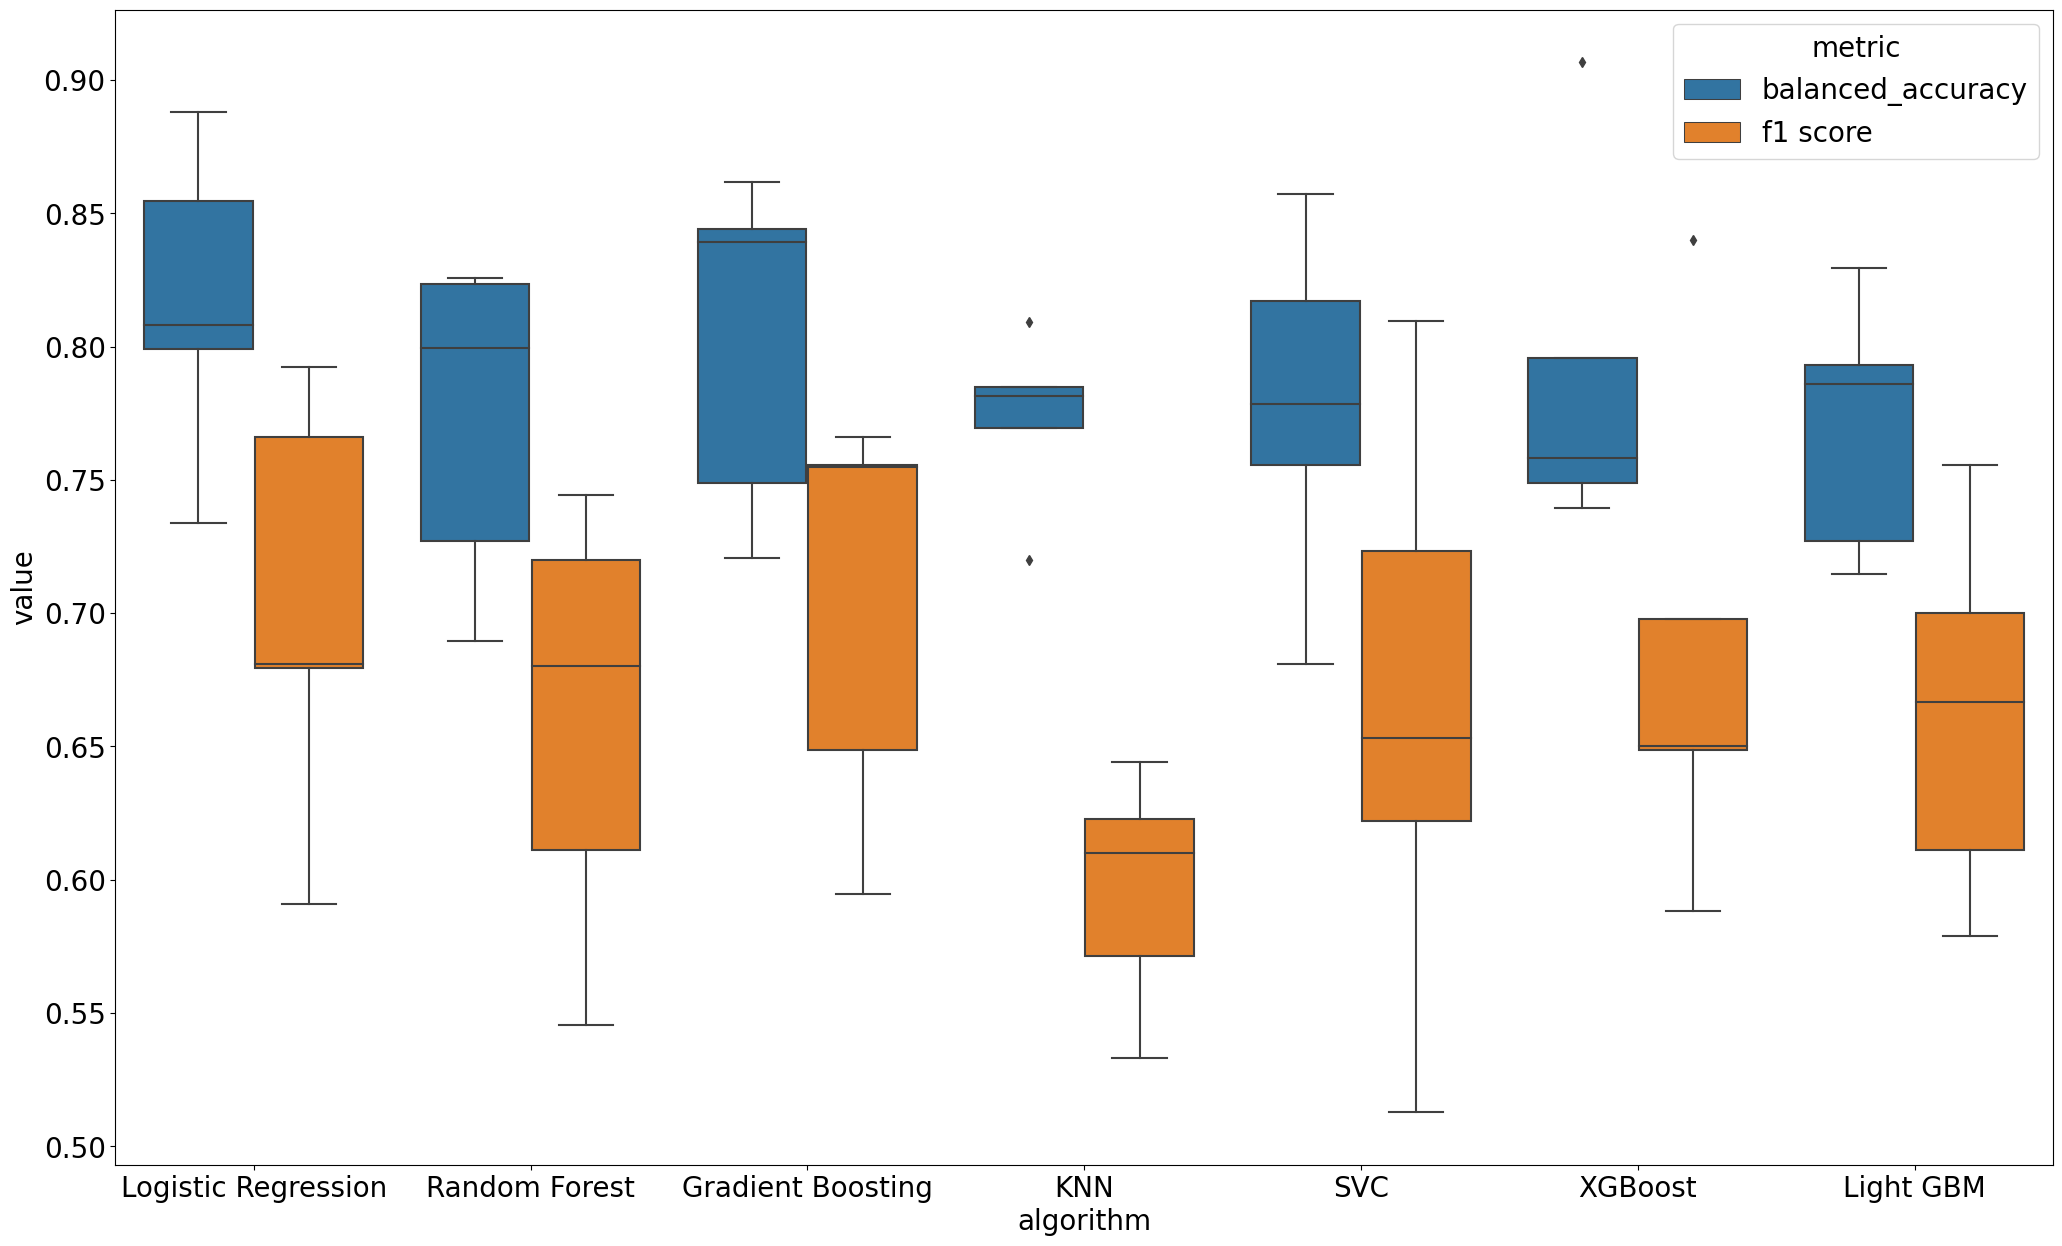

In [89]:
fig, ax = plt.subplots(figsize=(25,15))
sns.boxplot(x="algorithm", y="value", data=melted, hue="metric", ax=ax, meanline=True)

Text(0, 0.5, '')

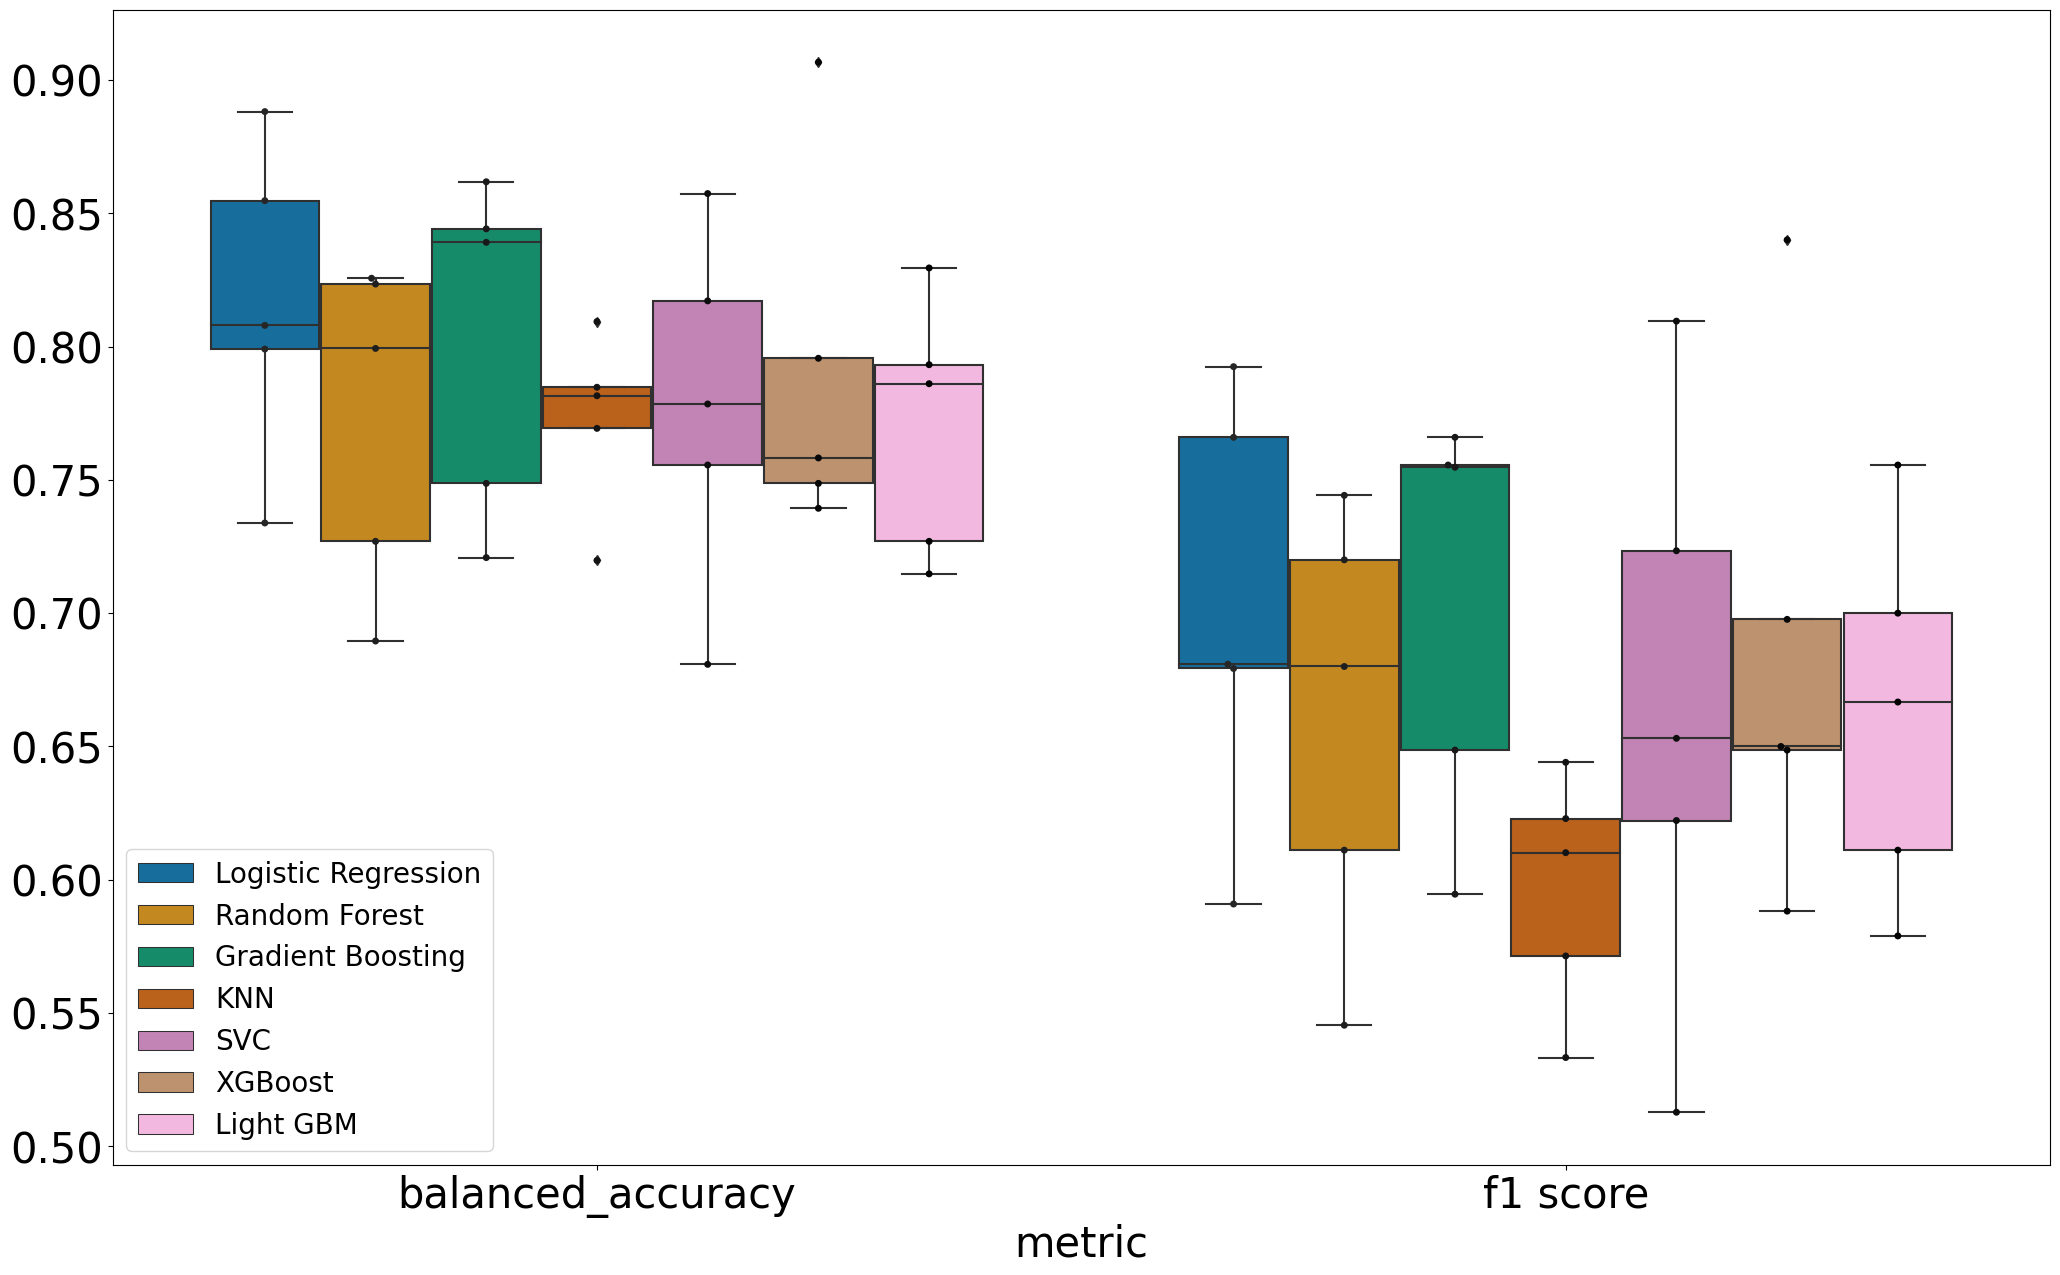

In [90]:
rcParams["font.size"] = 30
fig, ax = plt.subplots(figsize=(25,15))
sns.boxplot(x="metric", y="value", data=melted, hue="algorithm", ax=ax, palette="colorblind")
sns.swarmplot(x="metric", y="value", data=melted, hue="algorithm", ax=ax, dodge=True, color="k")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:7], labels[:7], fontsize=20)
ax.set_ylabel(None)

In [91]:
fig.savefig("cv_res_combined_pca.pdf")

# PCA visualization

In [45]:
from sklearn.metrics import confusion_matrix, roc_auc_score
from matplotlib import rcParams

rcParams["font.size"] = 20

In [46]:
xx = x
yy = y

In [47]:
scaler = StandardScaler()
pca = PCA(n_components=0.95)
xx = scaler.fit_transform(xx[fqd_columns+descriptors_names])
oob_x = scaler.transform(oob_x[fqd_columns+descriptors_names].fillna(0))

xx = pca.fit_transform(xx)
oob_x = pca.transform(oob_x)

In [48]:
loading_scores = pd.Series(pca.components_[0], index=fqd_columns+descriptors_names)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

print(sorted_loading_scores[:20])

FQD_4_nan            0.115381
quant_FQD_4_g298     0.115104
quant_FQD_4_u0       0.115104
quant_FQD_4_u298     0.115104
quant_FQD_4_h298     0.115104
quant_FQD_4_cv       0.114134
quant_FQD_4_homo     0.114110
quant_FQD_4_gap      0.113321
quant_FQD_4_alpha    0.113262
quant_FQD_4_zpve     0.111319
quant_FQD_5_cv       0.107884
quant_FQD_5_zpve     0.107049
FQD_3_nan            0.105227
quant_FQD_5_gap      0.105220
quant_FQD_3_cv       0.104867
quant_FQD_5_alpha    0.104373
quant_FQD_5_homo     0.104089
quant_FQD_3_g298     0.103736
quant_FQD_3_u0       0.103735
quant_FQD_3_u298     0.103735
dtype: float64


In [49]:
loading_scores = pd.Series(pca.components_[1], index=fqd_columns+descriptors_names)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

print(sorted_loading_scores[:20])

BertzCT                       0.122478
HeavyAtomMolWt                0.112493
HeavyAtomCount                0.112333
Chi1                          0.112150
ExactMolWt                    0.110569
MolWt                         0.110456
Chi0                          0.109840
LabuteASA                     0.108583
quant_FQD_2_alpha_per_atom    0.105775
quant_FQD_2_cv_per_atom       0.105631
quant_FQD_2_gap_per_atom      0.105559
quant_FQD_2_homo_per_atom     0.105358
quant_FQD_2_zpve_per_atom     0.105069
NumValenceElectrons           0.104329
MolMR                         0.102791
NumAromaticRings              0.099631
quant_FQD_2_lumo_per_atom     0.099581
quant_FQD_6_cv_per_atom       0.098788
Chi0v                         0.098629
quant_FQD_3_zpve_per_atom     0.098374
dtype: float64


In [50]:
loading_scores = pd.Series(pca.components_[2], index=fqd_columns+descriptors_names)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

print(sorted_loading_scores[:20])

quant_FQD_8_homo              0.138573
quant_FQD_7_g298              0.135872
quant_FQD_7_h298              0.135869
quant_FQD_7_u0                0.135869
quant_FQD_7_u298              0.135849
quant_FQD_8_alpha             0.134810
FQD_8_nan                     0.132786
quant_FQD_8_g298              0.132388
quant_FQD_8_u0                0.132386
quant_FQD_8_h298              0.132385
quant_FQD_8_u298              0.132367
quant_FQD_7_homo              0.130696
quant_FQD_8_gap               0.130298
quant_FQD_8_homo_per_atom     0.129571
FQD_7_nan                     0.125689
quant_FQD_7_alpha             0.125677
quant_FQD_8_cv                0.125613
quant_FQD_8_alpha_per_atom    0.125128
quant_FQD_9_u298              0.125038
quant_FQD_9_g298              0.125033
dtype: float64


In [51]:
loading_scores = pd.Series(pca.components_[3], index=fqd_columns+descriptors_names)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

print(sorted_loading_scores[:20])

PEOE_VSA6                    0.133508
FpDensityMorgan1             0.124895
quant_FQD_2_mu_per_atom      0.122483
MolLogP                      0.122027
quant_FQD_2_h298             0.112907
quant_FQD_2_u298             0.112907
quant_FQD_2_u0               0.112907
quant_FQD_2_g298             0.112903
quant_FQD_2_h298_per_atom    0.111122
quant_FQD_2_u298_per_atom    0.111122
quant_FQD_2_u0_per_atom      0.111121
quant_FQD_2_g298_per_atom    0.111117
quant_FQD_6_zpve             0.110536
FpDensityMorgan2             0.108853
quant_FQD_3_mu_per_atom      0.108506
MaxAbsPartialCharge          0.105684
MinPartialCharge             0.105589
MinAbsPartialCharge          0.103281
quant_FQD_7_lumo             0.102260
MaxPartialCharge             0.100551
dtype: float64


In [52]:
pca_df = pd.DataFrame(xx, columns=[f"PC{n}" for n in range(1, xx.shape[1]+1)])

In [53]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72
0,9.695179,4.528169,-0.446927,-0.727023,1.711090,-0.707989,-1.447874,-1.867948,1.926973,1.124594,...,0.542707,-0.482206,1.216795,-0.229184,0.927572,-0.794690,1.414544,-0.075771,1.450027,-1.278223
1,-8.464186,-1.525578,3.668253,5.509068,-1.847698,-5.808036,-0.849708,2.821459,-4.510478,2.220442,...,-0.505429,0.055002,-0.059279,0.396250,0.128517,0.239220,-0.655751,0.090854,0.670941,-0.092237
2,5.352140,-0.896335,-1.548601,-3.052735,-0.597273,0.632051,-3.651194,-2.068638,-0.611005,0.206839,...,1.215049,-0.369167,0.775566,0.142531,0.701439,1.647624,0.169773,-0.223396,0.334119,-0.533669
3,7.075199,1.032293,0.737506,1.532977,3.309760,-3.713544,-2.723482,-3.435944,0.589556,-0.104507,...,-1.227357,5.097129,2.427917,-1.152320,0.295568,2.716875,-0.005954,0.188854,0.991711,-0.424740
4,-5.181844,-3.503446,6.428290,6.285906,-0.007548,2.888307,0.005753,-1.201537,-1.178864,-1.454419,...,-0.173508,0.519353,0.244011,-0.814278,-0.011618,0.501497,0.061814,-0.173540,0.290408,-0.083351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,-5.799089,-7.473084,6.510456,6.183654,-2.244832,1.822311,-1.046048,-1.249851,0.376412,-0.697889,...,0.525534,-1.201542,-0.969491,0.084461,0.723069,0.362954,-0.235306,0.634431,0.058342,-0.015213
522,-4.080078,5.212119,-0.712012,-3.060780,-4.833691,-2.015790,-4.050702,0.879014,1.605720,1.449978,...,-0.618303,0.977671,0.142051,0.510381,-1.314123,0.626872,-0.222382,0.796122,-1.169188,0.761830
523,5.477449,-0.730370,0.115170,0.360565,3.391150,-2.962261,-2.873055,-4.067797,-0.377990,-0.958839,...,-1.381820,4.433134,2.895092,-0.278371,1.104664,3.611846,-0.129880,-0.300934,0.629348,-0.821120
524,5.900138,2.196195,-2.034783,-1.329622,0.294145,-0.061616,-4.003090,-2.939883,1.447728,1.140002,...,0.070736,-0.761505,0.468877,-0.881065,0.361470,0.926266,0.117826,-0.799992,1.301345,-0.359551


In [54]:
rcParams["font.size"] = 20

Text(0, 0.5, 'summary % variance explained')

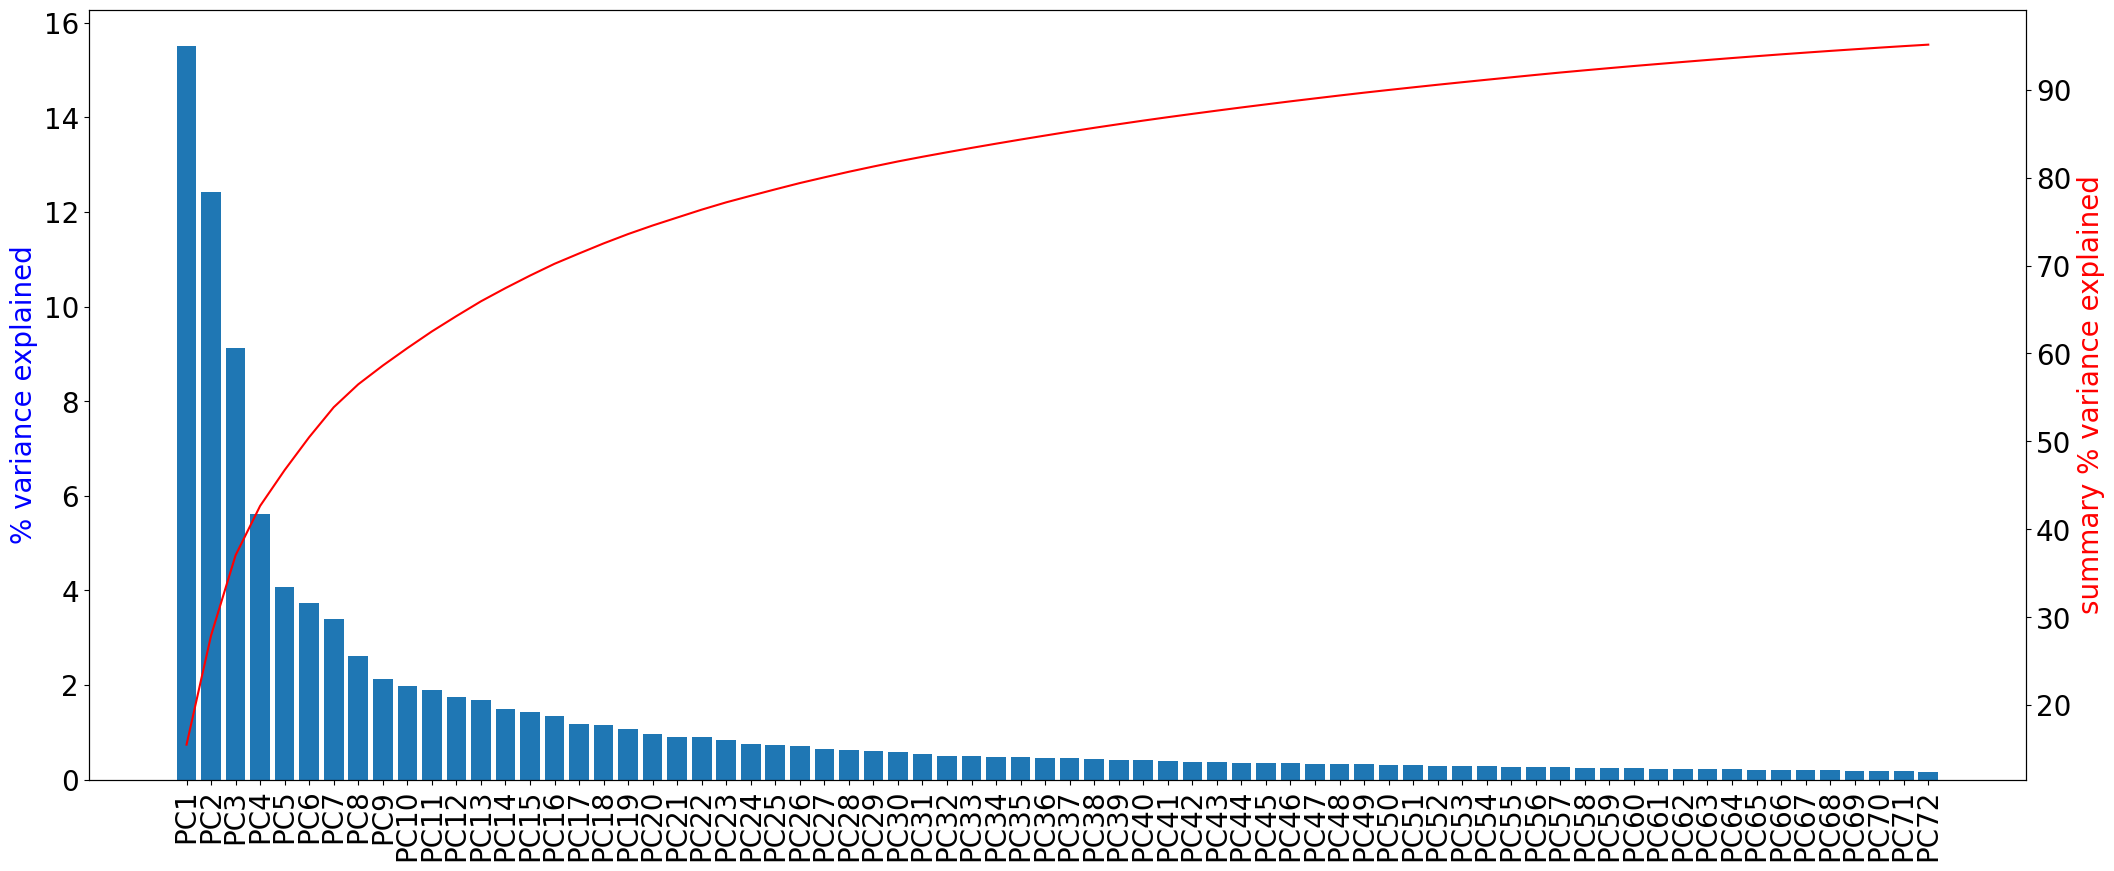

In [55]:
pcs = [f"PC{n}" for n in range(1, xx.shape[1]+1)]
fig, ax = plt.subplots(figsize=(25,10))
ax.bar(pcs, pca.explained_variance_ratio_*100)
ax.tick_params(axis="x", rotation=90)
ax2 = ax.twinx()
ax2.plot(pcs, (pca.explained_variance_ratio_*100).cumsum(), c="r")
ax.set_ylabel("% variance explained", color="b")
ax2.set_ylabel("summary % variance explained", color="r")

In [56]:
fig.savefig("scree_plot_comb.pdf")

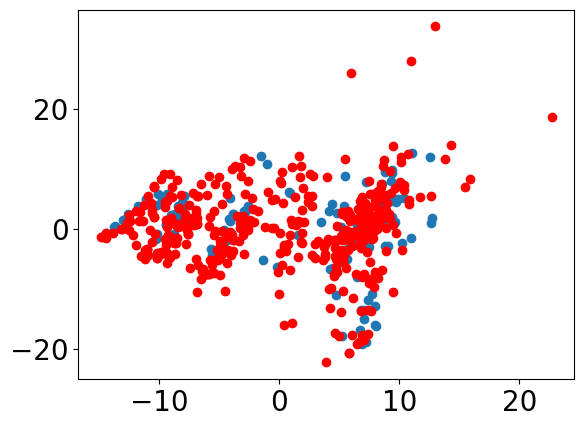

In [57]:
fig, ax = plt.subplots()
pca_df_ones = pca_df[(yy==1).values]
pca_df_zeros = pca_df[(yy==0).values]
ax.scatter(pca_df_ones["PC1"], pca_df_ones["PC2"])
ax.scatter(pca_df_zeros["PC1"], pca_df_zeros["PC2"], c="r")

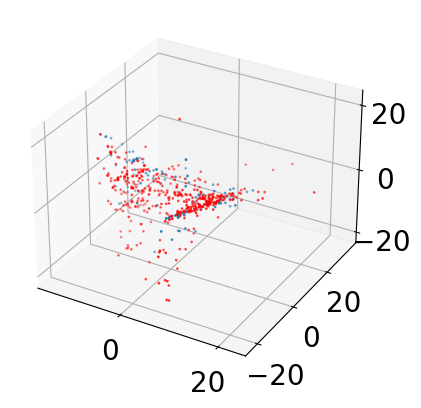

In [58]:
from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots(subplot_kw={"projection":"3d"})
ax.scatter(pca_df_ones["PC1"], pca_df_ones["PC2"], pca_df_ones["PC3"], s=1)
ax.scatter(pca_df_zeros["PC1"], pca_df_zeros["PC2"], pca_df_zeros["PC3"], c="r", s=1)

In [79]:
pd.concat([pca_df, yy.reset_index(drop=True)], axis=1).to_csv("pca_df_comb.csv")

# Mutual Information

## No PCA

In [60]:
from sklearn.feature_selection import mutual_info_classif

In [67]:
minf = mutual_info_classif(dat3.iloc[:, 14:].fillna(0), dat3["class_encoded"], random_state=1, n_neighbors=3)

In [68]:
minf = pd.Series(minf, index=dat3.columns[14:])

In [69]:
minf.sort_values(ascending=False).head(40)

MolLogP                      0.213168
MaxAbsPartialCharge          0.178831
MinPartialCharge             0.174407
BCUT2D_MRLOW                 0.150576
PEOE_VSA6                    0.150143
quant_FQD_7_mu_per_atom      0.144331
MaxEStateIndex               0.143449
MaxAbsEStateIndex            0.143139
LabuteASA                    0.134620
EState_VSA9                  0.133769
quant_FQD_8_u0               0.132992
quant_FQD_8_h298             0.131930
MaxPartialCharge             0.129840
quant_FQD_8_g298             0.125665
MolMR                        0.124899
quant_FQD_8_u298             0.124890
quant_FQD_9_u298             0.124793
MolWt                        0.123378
quant_FQD_8_zpve             0.119433
BCUT2D_MWHI                  0.118866
quant_FQD_2_u298_per_atom    0.117786
quant_FQD_2_g298_per_atom    0.117423
quant_FQD_2_u0_per_atom      0.117146
quant_FQD_9_h298             0.115694
HeavyAtomMolWt               0.114419
quant_FQD_7_lumo_per_atom    0.113875
Chi0v       

## PCA

In [75]:
minf = mutual_info_classif(pca_df, y, random_state=1, n_neighbors=3)

In [77]:
minf = pd.Series(minf, index=pca_df.columns)

In [78]:
minf.sort_values(ascending=False).head(40)

PC4     0.119560
PC6     0.086858
PC5     0.062171
PC33    0.055829
PC14    0.053400
PC51    0.051274
PC69    0.049875
PC3     0.047382
PC67    0.040323
PC42    0.040116
PC1     0.039641
PC24    0.038065
PC43    0.035186
PC62    0.035054
PC12    0.032922
PC7     0.032134
PC32    0.031818
PC56    0.028984
PC2     0.026468
PC70    0.026402
PC65    0.026275
PC61    0.025734
PC27    0.023816
PC64    0.020901
PC15    0.020856
PC52    0.020096
PC39    0.018706
PC41    0.017310
PC10    0.016807
PC19    0.016730
PC31    0.016401
PC8     0.015905
PC22    0.014578
PC13    0.013794
PC30    0.013581
PC55    0.012812
PC46    0.011324
PC34    0.010117
PC9     0.009120
PC54    0.008970
dtype: float64